In [1]:
%run local_functions.py
from local_functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import BertConfig, BertModel


from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
from transformers import TrainingArguments, Trainer


from sklearn.model_selection import train_test_split

plt.style.use("dark_background")

pd.set_option("display.max_columns", 2500)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 50)


plt.style.use("dark_background")

%load_ext lab_black

2023-09-01 09:53:44.948434: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 09:53:44.968969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 09:53:45.274202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)
df["text"] = df["headline"] + " " + df["short_description"]
df = df[["text", "category"]]
df["text"] = df["text"].apply(text_normalization_3)

SAMPLE_SIZE = 25000

df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

In [3]:
training_df, testing_df = train_test_split(df, test_size=0.25, random_state=42)

In [4]:
training_df

,text,category
6920,youtuber anna akana is done taking roles that ...,ENTERTAINMENT
17926,elin nordegren 10 things she is done since the...,DIVORCE
1123,anderson cooper jokes that his mom hooked up w...,MEDIA
4518,amplifyd com challenges starbucks and peet s c...,GREEN
5576,america needs to send john kerry to cop22 with...,THE WORLDPOST
...,...,...
21575,u s military soldier based in south korea test...,WORLD NEWS
5390,tips for your child s first summer sleep away ...,PARENTS
860,how kim jong un baited trump into canceling th...,WORLD NEWS
15795,lost recipes i try to remind myself how she di...,FOOD & DRINK


In [5]:
encoded_df = pd.get_dummies(
    training_df["category"], columns=["category"], prefix="", prefix_sep=""
)
encoded_df = encoded_df.astype(bool)
encoded_df_con = pd.concat([training_df["text"], encoded_df], axis=1)

# Dataset

In [6]:
train_df, temp_df = train_test_split(encoded_df_con, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [7]:
# Convert the split DataFrames into Datasets
train = Dataset.from_pandas(train_df, split="train")
valid = Dataset.from_pandas(valid_df, split="validation")
test = Dataset.from_pandas(test_df, split="test")

dataset = DatasetDict({"train": train, "validation": valid, "test": test})

In [8]:
labels = [
    label
    for label in dataset["train"].features.keys()
    if label not in ["text", "__index_level_0__"]
]
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Tokenize

In [9]:
LM = "bert-base-uncased"

In [10]:
tokenizer = AutoTokenizer.from_pretrained(LM)

In [38]:
def preprocess_data(examples):
    # take a batch of texts
    text = examples["text"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=256)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding


encoded_dataset = dataset.map(
    preprocess_data, batched=True, remove_columns=dataset["train"].column_names
)

encoded_dataset.set_format("torch")

Map:   0%|          | 0/13125 [00:00<?, ? examples/s]

Map:   0%|          | 0/2812 [00:00<?, ? examples/s]

Map:   0%|          | 0/2813 [00:00<?, ? examples/s]

In [39]:
model = AutoModelForSequenceClassification.from_pretrained(
    LM,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
batch_size = 8
metric_name = "f1"

In [41]:
args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    # push_to_hub=True,
)

In [42]:
def multi_label_metrics(
    predictions, labels, threshold=0.5
):  # threshold = confidence threshold, important. 0.5 doesnt always work
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # use threshold to turn them into int predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    roc_auc = roc_auc_score(y_true, y_pred, average="micro")
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {"f1": f1_micro_average, "roc_auc": roc_auc, "accuracy": accuracy}
    return metrics


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

In [43]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [44]:
trainer.train()

/home/luke/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/8205 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.1717, 'learning_rate': 1.87812309567337e-05, 'epoch': 0.3}
{'loss': 0.0944, 'learning_rate': 1.7562461913467398e-05, 'epoch': 0.61}
{'loss': 0.0832, 'learning_rate': 1.6343692870201096e-05, 'epoch': 0.91}


  0%|          | 0/352 [00:00<?, ?it/s]

{'eval_loss': 0.07569011300802231, 'eval_f1': 0.35810446957458264, 'eval_roc_auc': 0.6172154182423758, 'eval_accuracy': 0.23648648648648649, 'eval_runtime': 16.6632, 'eval_samples_per_second': 168.755, 'eval_steps_per_second': 21.124, 'epoch': 1.0}
{'loss': 0.0714, 'learning_rate': 1.5124923826934796e-05, 'epoch': 1.22}
{'loss': 0.0649, 'learning_rate': 1.3906154783668494e-05, 'epoch': 1.52}
{'loss': 0.0619, 'learning_rate': 1.2687385740402194e-05, 'epoch': 1.83}


  0%|          | 0/352 [00:00<?, ?it/s]

{'eval_loss': 0.060076575726270676, 'eval_f1': 0.5273446590644636, 'eval_roc_auc': 0.6999314783332755, 'eval_accuracy': 0.40291607396870555, 'eval_runtime': 16.6423, 'eval_samples_per_second': 168.967, 'eval_steps_per_second': 21.151, 'epoch': 2.0}
{'loss': 0.0559, 'learning_rate': 1.1468616697135894e-05, 'epoch': 2.13}
{'loss': 0.0501, 'learning_rate': 1.0249847653869594e-05, 'epoch': 2.44}
{'loss': 0.048, 'learning_rate': 9.03107861060329e-06, 'epoch': 2.74}


  0%|          | 0/352 [00:00<?, ?it/s]

{'eval_loss': 0.055335044860839844, 'eval_f1': 0.565286263860602, 'eval_roc_auc': 0.7205313464941193, 'eval_accuracy': 0.4441678520625889, 'eval_runtime': 15.7393, 'eval_samples_per_second': 178.661, 'eval_steps_per_second': 22.364, 'epoch': 3.0}
{'loss': 0.0465, 'learning_rate': 7.81230956733699e-06, 'epoch': 3.05}
{'loss': 0.04, 'learning_rate': 6.59354052407069e-06, 'epoch': 3.35}
{'loss': 0.0403, 'learning_rate': 5.374771480804388e-06, 'epoch': 3.66}
{'loss': 0.0393, 'learning_rate': 4.156002437538087e-06, 'epoch': 3.96}


  0%|          | 0/352 [00:00<?, ?it/s]

{'eval_loss': 0.05379441753029823, 'eval_f1': 0.5949913644214162, 'eval_roc_auc': 0.7431044651840545, 'eval_accuracy': 0.4900426742532006, 'eval_runtime': 15.7378, 'eval_samples_per_second': 178.678, 'eval_steps_per_second': 22.367, 'epoch': 4.0}
{'loss': 0.0352, 'learning_rate': 2.9372333942717856e-06, 'epoch': 4.27}
{'loss': 0.0339, 'learning_rate': 1.7184643510054846e-06, 'epoch': 4.57}
{'loss': 0.0346, 'learning_rate': 4.996953077391835e-07, 'epoch': 4.88}


  0%|          | 0/352 [00:00<?, ?it/s]

{'eval_loss': 0.05378809571266174, 'eval_f1': 0.5902134080620823, 'eval_roc_auc': 0.7414347916594386, 'eval_accuracy': 0.4868421052631579, 'eval_runtime': 15.7379, 'eval_samples_per_second': 178.677, 'eval_steps_per_second': 22.366, 'epoch': 5.0}
{'train_runtime': 1420.1854, 'train_samples_per_second': 46.209, 'train_steps_per_second': 5.777, 'train_loss': 0.060044924011323456, 'epoch': 5.0}


TrainOutput(global_step=8205, training_loss=0.060044924011323456, metrics={'train_runtime': 1420.1854, 'train_samples_per_second': 46.209, 'train_steps_per_second': 5.777, 'train_loss': 0.060044924011323456, 'epoch': 5.0})

In [45]:
trainer.evaluate()

  0%|          | 0/352 [00:00<?, ?it/s]

{'eval_loss': 0.05379441753029823,
 'eval_f1': 0.5949913644214162,
 'eval_roc_auc': 0.7431044651840545,
 'eval_accuracy': 0.4900426742532006,
 'eval_runtime': 16.5024,
 'eval_samples_per_second': 170.399,
 'eval_steps_per_second': 21.33,
 'epoch': 5.0}

In [46]:
#trainer.save_model("bert-finetuned-news-headlines")

# Eval - Training 23 mins

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-finetuned-news-headlines"
)
trainer = Trainer(model=model, tokenizer=tokenizer)

In [12]:
df_test = testing_df.reset_index(drop=True)

In [13]:
df_test

,text,category
0,the mistake that leads to better brownies most...,FOOD & DRINK
1,after the shooting at spu desolation consolati...,RELIGION
2,gordon ramsay sued over unpaid wages by employ...,BUSINESS
3,fire breaks out at mexico s top refinery 9 peo...,WORLD NEWS
4,20 ways to make your marriage stronger grooms ...,WEDDINGS
...,...,...
6245,scott weiland died from toxic mix of drugs acc...,ENTERTAINMENT
6246,15 reasons why october is the best time to vis...,TRAVEL
6247,teen allegedly held captive is feeling a lot b...,CRIME
6248,take a look at the best animal photos of the week,GREEN


In [88]:
ROWS_TO_EVALUATE = len(df_test)

CONFIDENCE_THRESHOLD = 0.65  # 0.1 works well for low number of non-responses

TOP_N_PREDS = 5  # number of top predictions to return


# make predictions
df_test["predicted_class"] = df_test["text"][0:ROWS_TO_EVALUATE].apply(
    predict_class, args=(tokenizer, trainer, id2label, CONFIDENCE_THRESHOLD)
)  # args: text, tokenizer, trainer, id2label, CONFIDENCE_THRESHOLD=0.5

# calculate if prediction is correct
df_test["correct"] = df_test[0:ROWS_TO_EVALUATE].apply(
    lambda row: int(row["category"] in row["predicted_class"]), axis=1
)
# calculate score (including penalty for guessing multiple categories) used to help find optimal confidence threshold
df_test["correct_w_discount"] = df_test[0:ROWS_TO_EVALUATE].apply(
    multi_cat_guess_penalty,
    axis=1,
    args=(0.9,),  # muli_cat_guess_penalty (somewhere around 0.85 works well)
)

df_test["correct_w_non_preds"] = df_test.apply(multi_positive_outcome, axis=1)

# get top n predictions
df_test["top_n_preds"] = df_test["text"][0:ROWS_TO_EVALUATE].apply(
    n_most_likely_classes, args=(tokenizer, trainer, id2label, TOP_N_PREDS)
)

print(
    f"Percent of predictions that include correct class: {round((df_test.correct.sum() / ROWS_TO_EVALUATE)*100, 2)}%"
)
print(
    f"Multi_guess discount score: {round((df_test.correct_w_discount.sum() / ROWS_TO_EVALUATE)*100, 2)}%"
)
print(
    f"Multi_positive_outcome discount score: {round((df_test.correct_w_non_preds.sum() / ROWS_TO_EVALUATE)*100, 2)}%"
)

print(
    f"Percent of non-preds: {round((df_test.correct_w_non_preds.sum() - df_test.correct.sum()) / ROWS_TO_EVALUATE*100, 2)}% "
)
print(
    f"Percent of wrong preds: {round((1-(df_test.correct_w_non_preds.sum() / ROWS_TO_EVALUATE))*100,2)}%"
)

Percent of predictions that include correct class: 41.36%
Multi_guess discount score: 41.36%
Multi_positive_outcome discount score: 89.79%
Percent of non-preds: 48.43% 
Percent of wrong preds: 10.21%


In [14]:
df_test

,text,category
0,the mistake that leads to better brownies most...,FOOD & DRINK
1,after the shooting at spu desolation consolati...,RELIGION
2,gordon ramsay sued over unpaid wages by employ...,BUSINESS
3,fire breaks out at mexico s top refinery 9 peo...,WORLD NEWS
4,20 ways to make your marriage stronger grooms ...,WEDDINGS
...,...,...
6245,scott weiland died from toxic mix of drugs acc...,ENTERTAINMENT
6246,15 reasons why october is the best time to vis...,TRAVEL
6247,teen allegedly held captive is feeling a lot b...,CRIME
6248,take a look at the best animal photos of the week,GREEN


Confidence Threshold: 0.05
Percent of predictions that include correct class: 78.72%
Multi_guess discount score: 64.67%
Multi_positive_outcome discount score: 78.74%
Percent of non-preds: 0.02% 
Percent of wrong preds: 21.26%
Confidence Threshold: 0.1
Percent of predictions that include correct class: 71.89%
Multi_guess discount score: 64.76%
Multi_positive_outcome discount score: 72.66%
Percent of non-preds: 0.77% 
Percent of wrong preds: 27.34%
Confidence Threshold: 0.15000000000000002
Percent of predictions that include correct class: 67.44%
Multi_guess discount score: 63.15%
Multi_positive_outcome discount score: 70.93%
Percent of non-preds: 3.49% 
Percent of wrong preds: 29.07%
Confidence Threshold: 0.2
Percent of predictions that include correct class: 63.04%
Multi_guess discount score: 60.8%
Multi_positive_outcome discount score: 71.09%
Percent of non-preds: 8.05% 
Percent of wrong preds: 28.91%
Confidence Threshold: 0.25
Percent of predictions that include correct class: 59.55%

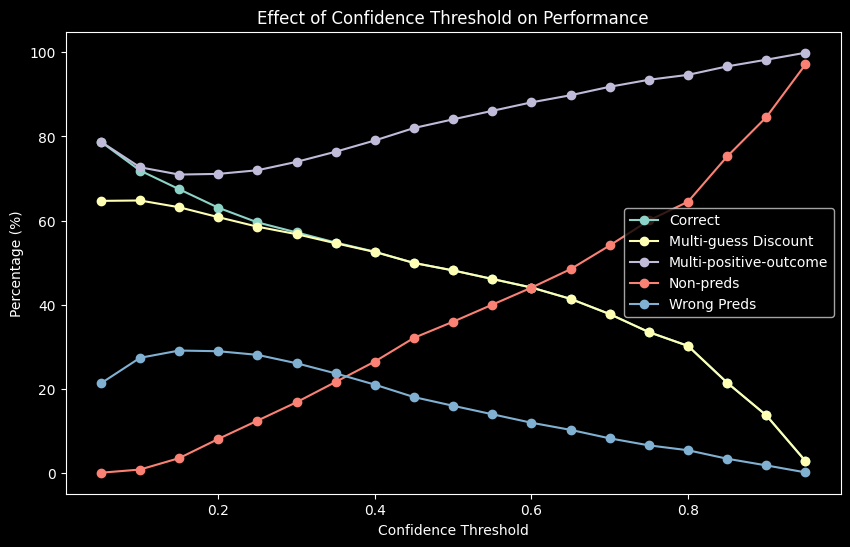

In [15]:
ROWS_TO_EVALUATE = len(df_test)
TOP_N_PREDS = 5

thresholds = []
percent_correct_list = []
percent_correct_discount_list = []
percent_correct_non_preds_list = []
percent_non_preds_list = []
percent_wrong_preds_list = []


for CONFIDENCE_THRESHOLD in np.arange(0.05, 1, 0.05):
    df_test["predicted_class"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        predict_class, args=(tokenizer, trainer, id2label, CONFIDENCE_THRESHOLD)
    )

    df_test["correct"] = df_test[:ROWS_TO_EVALUATE].apply(
        lambda row: int(row["category"] in row["predicted_class"]), axis=1
    )

    df_test["correct_w_discount"] = df_test[:ROWS_TO_EVALUATE].apply(
        multi_cat_guess_penalty, axis=1, args=(0.9,)
    )

    df_test["correct_w_non_preds"] = df_test[:ROWS_TO_EVALUATE].apply(
        multi_positive_outcome, axis=1
    )

    df_test["top_n_preds"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        n_most_likely_classes, args=(tokenizer, trainer, id2label, TOP_N_PREDS)
    )

    percent_correct = (df_test["correct"].sum() / ROWS_TO_EVALUATE) * 100
    percent_correct_discount = (
        df_test["correct_w_discount"].sum() / ROWS_TO_EVALUATE
    ) * 100
    percent_correct_non_preds = (
        df_test["correct_w_non_preds"].sum() / ROWS_TO_EVALUATE
    ) * 100

    percent_non_preds = (
        len(df_test[df_test.predicted_class.str.len() == 0]) / ROWS_TO_EVALUATE
    ) * 100
    percent_wrong_preds = (
        1 - (df_test.correct_w_non_preds.sum() / ROWS_TO_EVALUATE)
    ) * 100

    thresholds.append(CONFIDENCE_THRESHOLD)
    percent_correct_list.append(percent_correct)
    percent_correct_discount_list.append(percent_correct_discount)
    percent_correct_non_preds_list.append(percent_correct_non_preds)
    percent_non_preds_list.append(percent_non_preds)
    percent_wrong_preds_list.append(percent_wrong_preds)

    print(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}")
    print(
        f"Percent of predictions that include correct class: {round(percent_correct, 2)}%"
    )
    print(f"Multi_guess discount score: {round(percent_correct_discount, 2)}%")
    print(
        f"Multi_positive_outcome discount score: {round(percent_correct_non_preds, 2)}%"
    )
    print(f"Percent of non-preds: {round(percent_non_preds, 2)}% ")
    print(f"Percent of wrong preds: {round(percent_wrong_preds, 2)}%")
    print("=" * 75)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, percent_correct_list, marker="o", label="Correct")
plt.plot(
    thresholds, percent_correct_discount_list, marker="o", label="Multi-guess Discount"
)
plt.plot(
    thresholds,
    percent_correct_non_preds_list,
    marker="o",
    label="Multi-positive-outcome",
)

plt.plot(thresholds, percent_non_preds_list, marker="o", label="Non-preds")
plt.plot(thresholds, percent_wrong_preds_list, marker="o", label="Wrong Preds")


plt.xlabel("Confidence Threshold")
plt.ylabel("Percentage (%)")
plt.title("Effect of Confidence Threshold on Performance")
plt.legend()
plt.grid(False)
plt.show()

In [16]:
data = {
    "threshold": thresholds,
    "correct": percent_correct_list,
    "correct_discount": percent_correct_discount_list,
    "correct_non_preds": percent_correct_non_preds_list,
    "non_preds": percent_non_preds_list,
    "wrong_preds": percent_wrong_preds_list,
}

In [17]:
results_df = pd.DataFrame(data)
results_df = results_df.round(2)

In [18]:
results_df

,threshold,correct,correct_discount,correct_non_preds,non_preds,wrong_preds
0,0.05,78.72,64.67,78.74,0.02,21.26
1,0.10,71.89,64.76,72.66,0.77,27.34
2,0.15,67.44,63.15,70.93,3.49,29.07
3,0.20,63.04,60.80,71.09,8.05,28.91
4,0.25,59.55,58.53,71.95,12.40,28.05
5,0.30,57.17,56.75,73.95,16.78,26.05
6,0.35,54.75,54.58,76.37,21.62,23.63
7,0.40,52.58,52.51,79.04,26.46,20.96
8,0.45,49.90,49.90,82.00,32.10,18.00
9,0.50,48.13,48.13,84.06,35.94,15.94
